In [1]:
# Notebook: Hypothesis H1/H1v - Cost vs. Outcome Analysis

# --- Imports ---
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting H1/H1v Analysis: Cost vs. Outcome ---")


--- Starting H1/H1v Analysis: Cost vs. Outcome ---


In [2]:
# --- 1. Load CLEANED Data ---
# Use the filename generated by the Part 1 script
cleaned_data_file = 'wbg_merged_cleaned_2.csv' # Or 'wbg_merged_cleaned_2.csv' if you renamed it
print(f"\nLoading cleaned data from: {cleaned_data_file}")
try:
    # --- V V V --- USING header=1 AS SUGGESTED --- V V V ---
    df_analysis = pd.read_csv(
        cleaned_data_file,
        header=1,          # <--- Tells pandas the header is on the SECOND row (index 1)
        delimiter=',',     # Keep explicitly stating the delimiter
        low_memory=False
    )
    print(f"Loaded cleaned data successfully. Shape: {df_analysis.shape}")
    # --- >>> CHECK THIS OUTPUT CAREFULLY <<< ---
    print(f"Columns found after loading with header=1: {df_analysis.columns.tolist()}")
    # This list should now show the correct headers like ['project_id_merged', 'outcome', 'lendprojectcost', ...]

except FileNotFoundError:
    print(f"Error: File not found - {cleaned_data_file}.")
    print("Please ensure you have successfully run the 'Part 1' script first to generate this file.")
    exit()
except Exception as e:
    print(f"Error loading {cleaned_data_file}: {e}")
    print("Check if the header=1 setting is correct by inspecting the CSV file.")
    exit()



Loading cleaned data from: wbg_merged_cleaned_2.csv
Loaded cleaned data successfully. Shape: (6098, 15)
Columns found after loading with header=1: ['project_id_merged', 'outcome', 'country_economy_lending_group', 'global_practice', 'lending_instrument_type', 'practice_group', 'quality_at_entry', 'approval_fy', 'country_economy_fcs_status', 'lendinginstrtype', 'boardapprovaldate', 'lendprojectcost', 'regionname', 'countryname', 'outcomescore']


In [3]:
# --- 2. Define Columns Needed ---
# These names must match columns in the cleaned CSV
outcome_col = 'outcome' # Text outcome column
cost_col = 'lendprojectcost' # Cost column
print(f"\nUsing columns: Outcome='{outcome_col}', Cost='{cost_col}'")



Using columns: Outcome='outcome', Cost='lendprojectcost'


In [4]:
# --- 3. Preprocess Columns for H1/H1v ---
required_cols = [outcome_col, cost_col]
missing = [col for col in required_cols if col not in df_analysis.columns]
if missing: print(f"Error: Missing required columns: {missing}"); exit()


In [5]:
# Handle Missing Values
print(f"\nMissing values before H1/H1v drop:\n{df_analysis[required_cols].isnull().sum()}")
df_analysis.dropna(subset=required_cols, inplace=True)
print(f"Shape after dropping NAs: {df_analysis.shape}")
if df_analysis.empty: print("Error: Data empty after NA drop."); exit()

# Ensure Cost is numeric (should be from Part 1, but double-check)
df_analysis[cost_col] = pd.to_numeric(df_analysis[cost_col], errors='coerce')
df_analysis.dropna(subset=[cost_col], inplace=True) # Drop if conversion failed

# Binarize Outcome column (using text mapping)
print(f"\nPreprocessing outcome column '{outcome_col}'...")
df_analysis[outcome_col] = df_analysis[outcome_col].astype(str).str.strip()
unique_outcomes = df_analysis[outcome_col].unique()
print(f"Unique values found in '{outcome_col}': {unique_outcomes}")
# *** REVIEW & ADJUST MAPPING LISTS IF NEEDED ***
satisfactory_ratings = ['Satisfactory', 'Moderately Satisfactory', 'Highly Satisfactory', 'SA', 'MS', 'HS']
unsatisfactory_ratings = ['Unsatisfactory', 'Moderately Unsatisfactory', 'Highly Unsatisfactory', 'U', 'MU', 'HU']
def map_text_outcome(txt):
    if txt in unsatisfactory_ratings: return 1
    elif txt in satisfactory_ratings: return 0
    else: return np.nan
df_analysis['outcome_binary'] = df_analysis[outcome_col].apply(map_text_outcome)
unmapped_count = df_analysis['outcome_binary'].isnull().sum()
if unmapped_count > 0:
    unmapped_vals = df_analysis[df_analysis['outcome_binary'].isnull()][outcome_col].unique(); print(f"Warning: {unmapped_count} rows had unmapped outcome values ({unmapped_vals}). Dropping.")
    df_analysis.dropna(subset=['outcome_binary'], inplace=True)
df_analysis['outcome_binary'] = df_analysis['outcome_binary'].astype(int)
print("Created 'outcome_binary' (1=Unsat, 0=Sat).")
print(f"Value counts for outcome_binary:\n{df_analysis['outcome_binary'].value_counts(dropna=False)}")
if df_analysis['outcome_binary'].nunique() < 2: print("Error: Only one outcome category present."); exit()
outcome_binary_col = 'outcome_binary' # Define for consistency
print(f"Final data shape for H1/H1v analysis: {df_analysis.shape}")



Missing values before H1/H1v drop:
outcome             0
lendprojectcost    49
dtype: int64
Shape after dropping NAs: (6049, 15)

Preprocessing outcome column 'outcome'...
Unique values found in 'outcome': ['Moderately Satisfactory' 'Satisfactory' 'Moderately Unsatisfactory'
 'Unsatisfactory' 'Highly Satisfactory' 'Highly Unsatisfactory']
Created 'outcome_binary' (1=Unsat, 0=Sat).
Value counts for outcome_binary:
outcome_binary
0    4525
1    1524
Name: count, dtype: int64
Final data shape for H1/H1v analysis: (6049, 16)



--- Testing H1: Difference in Mean Cost ('lendprojectcost') vs. Outcome ---
Mean Cost (Unsat, N=1524): 136,680,544.62
Mean Cost (Sat, N=4525): 215,406,218.78
T-statistic: -4.5005, P-value: 6.913e-06
Result H1: Reject H0 (p < 0.05). Significant difference in mean costs.
  Interpretation: Satisfactory projects have significantly HIGHER mean costs (or Unsatisfactory have lower).


<ipython-input-6-8c0f6f6650dc>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  current_values = plt.gca().get_yticks(); plt.gca().set_yticklabels([f'{x:,.0f}' for x in current_values])


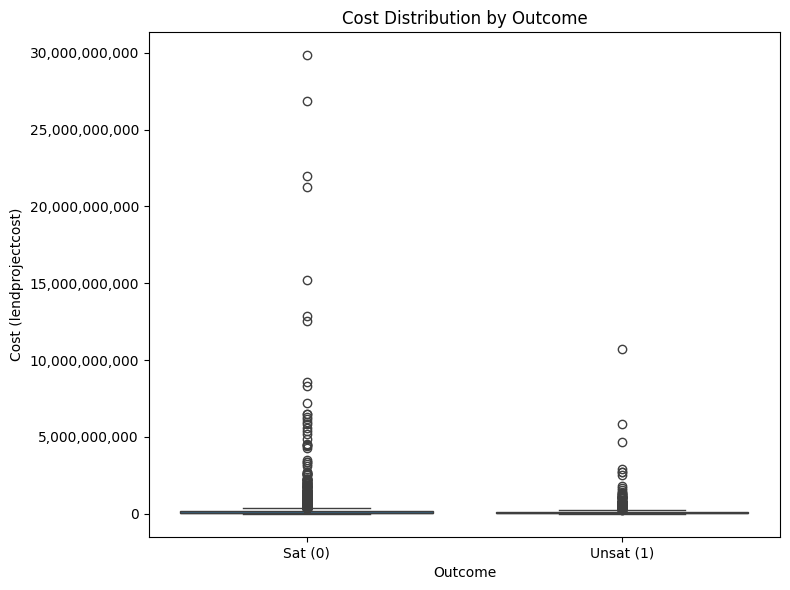

In [6]:
# --- 4. Test Hypothesis H1 (Mean Difference) ---
print(f"\n--- Testing H1: Difference in Mean Cost ('{cost_col}') vs. Outcome ---")
alpha = 0.05
cost_satisfactory = df_analysis[df_analysis[outcome_binary_col] == 0][cost_col]
cost_unsatisfactory = df_analysis[df_analysis[outcome_binary_col] == 1][cost_col]
if len(cost_satisfactory) < 2 or len(cost_unsatisfactory) < 2: print(f"Warning H1: Not enough data for t-test.")
else:
    t_stat, p_value_h1 = stats.ttest_ind(cost_unsatisfactory, cost_satisfactory, equal_var=False, nan_policy='omit')
    print(f"Mean Cost (Unsat, N={len(cost_unsatisfactory)}): {cost_unsatisfactory.mean():,.2f}")
    print(f"Mean Cost (Sat, N={len(cost_satisfactory)}): {cost_satisfactory.mean():,.2f}")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value_h1:.4g}")
    # Interpretation (Null = No difference in means)
    if p_value_h1 < alpha:
        print(f"Result H1: Reject H0 (p < {alpha}). Significant difference in mean costs.")
        # Interpretation based on your revised hypothesis exploration (Higher Cost -> Higher/Sat Outcome)
        if t_stat < 0: # t_stat = mean(unsat) - mean(sat). Negative means mean(sat) > mean(unsat)
             print("  Interpretation: Satisfactory projects have significantly HIGHER mean costs (or Unsatisfactory have lower).")
        else: # t_stat > 0 means mean(unsat) > mean(sat)
             print("  Interpretation: Unsatisfactory projects have significantly HIGHER mean costs.")
    else:
        print(f"Result H1: Fail to reject H0 (p >= {alpha}). No significant difference found in mean costs.")
    try: # Visualization H1
        plt.figure(figsize=(8, 6)); sns.boxplot(x=outcome_binary_col, y=cost_col, data=df_analysis)
        plt.title('Cost Distribution by Outcome'); plt.xlabel('Outcome'); plt.ylabel(f'Cost ({cost_col})')
        current_values = plt.gca().get_yticks(); plt.gca().set_yticklabels([f'{x:,.0f}' for x in current_values])
        plt.xticks([0, 1], ['Sat (0)', 'Unsat (1)']); plt.tight_layout(); plt.show()
    except Exception as e: print(f"Plot H1 Error: {e}")


<ipython-input-10-5977f3b0eb47>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  current_values = plt.gca().get_yticks(); plt.gca().set_yticklabels([f'{x:,.0f}' for x in current_values]) # Format y-ticks


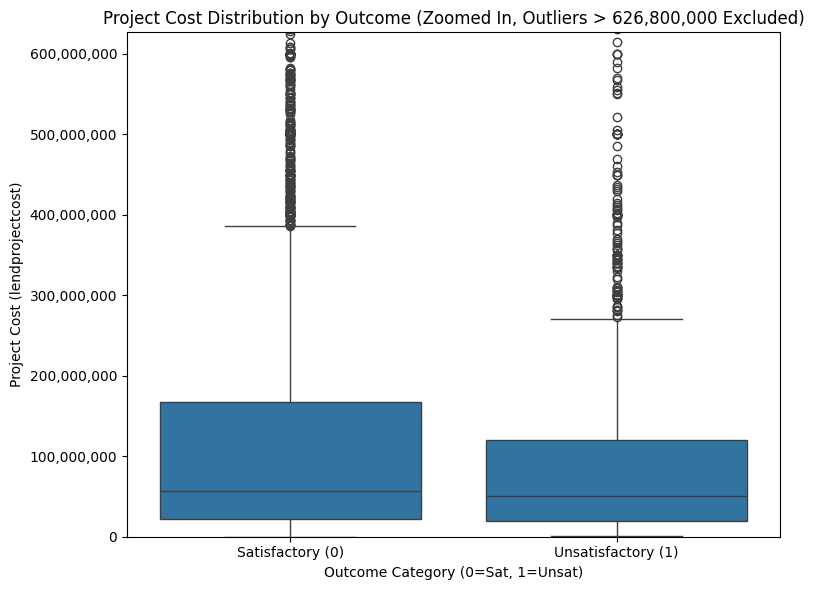

In [10]:
# Example Code Modification
plt.figure(figsize=(8, 6))
sns.boxplot(x=outcome_binary_col, y=cost_col, data=df_analysis)

# Calculate an upper limit, e.g., 95th percentile (adjust as needed)
upper_limit = df_analysis[cost_col].quantile(0.95)
plt.ylim(0, upper_limit) # Set y-axis limits

plt.title(f'Project Cost Distribution by Outcome (Zoomed In, Outliers > {upper_limit:,.0f} Excluded)')
plt.xlabel('Outcome Category (0=Sat, 1=Unsat)')
plt.ylabel(f'Project Cost ({cost_col})')
plt.xticks([0, 1], ['Satisfactory (0)', 'Unsatisfactory (1)'])
current_values = plt.gca().get_yticks(); plt.gca().set_yticklabels([f'{x:,.0f}' for x in current_values]) # Format y-ticks
plt.tight_layout()
plt.show()

In [7]:
# --- 5. Test Hypothesis H1v (Variance Difference) ---
print(f"\n--- Testing H1v: Difference in Variance of Cost ('{cost_col}') vs. Outcome ---")
if len(cost_satisfactory) < 3 or len(cost_unsatisfactory) < 3: print(f"Warning H1v: Not enough data for Levene's test.")
else:
    try: # Levene's Test
        levene_stat, p_value_levene = stats.levene(cost_satisfactory, cost_unsatisfactory, center='median')
        print(f"Levene's Test: Statistic={levene_stat:.4f}, P-value={p_value_levene:.4g}")
        # Interpretation (Null = Equal variances)
        if p_value_levene < alpha: print(f"Result H1v: Reject H0 (p < {alpha}). Significant difference in cost variance.")
        else: print(f"Result H1v: Fail to reject H0 (p >= {alpha}). No significant difference in cost variance.")
        print(f"  Std Dev (Sat): {cost_satisfactory.std():,.2f}, Std Dev (Unsat): {cost_unsatisfactory.std():,.2f}")
    except Exception as e: print(f"Error during Levene's test: {e}")

print("\n--- H1/H1v Analysis Complete ---")


--- Testing H1v: Difference in Variance of Cost ('lendprojectcost') vs. Outcome ---
Levene's Test: Statistic=9.2684, P-value=0.002341
Result H1v: Reject H0 (p < 0.05). Significant difference in cost variance.
  Std Dev (Sat): 947,868,198.98, Std Dev (Unsat): 404,641,733.42

--- H1/H1v Analysis Complete ---


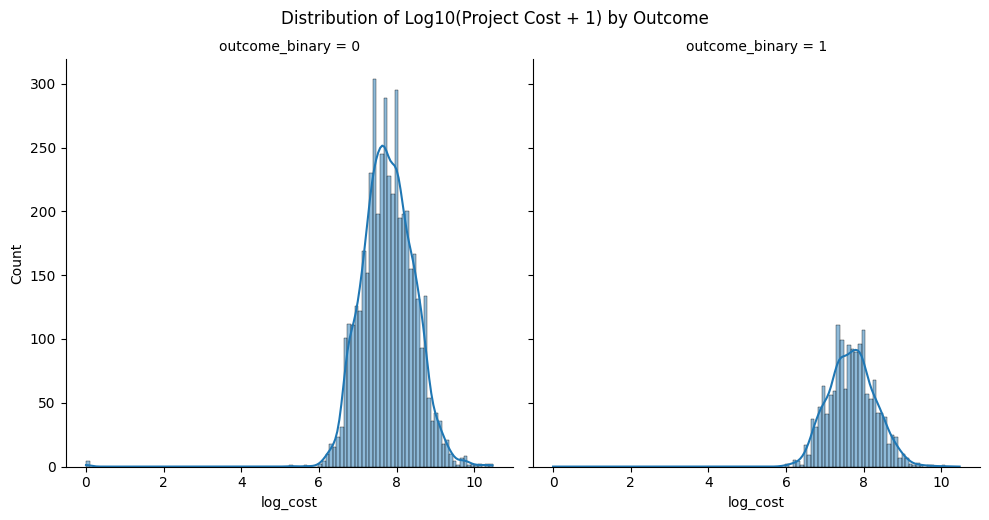

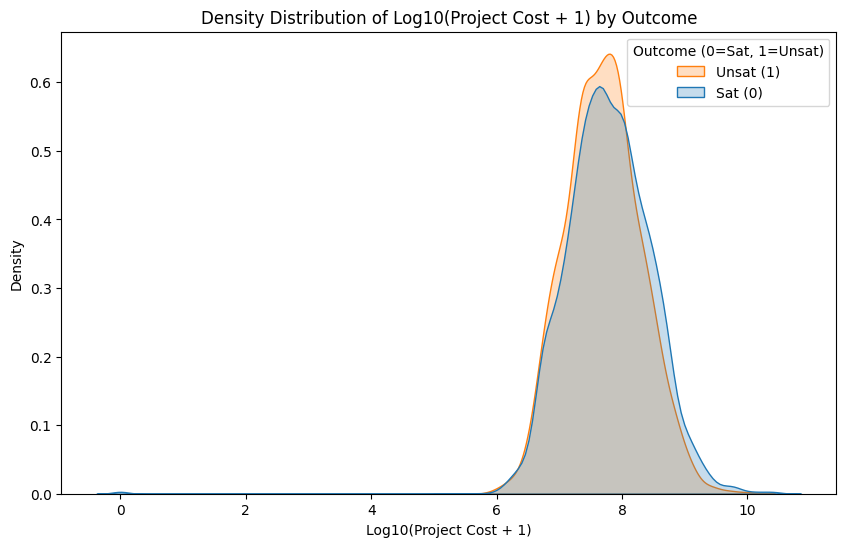

In [9]:
# Using Faceted Histograms
# Calculate log cost (add small value if zeros exist, e.g., 1)
df_analysis['log_cost'] = np.log10(df_analysis[cost_col] + 1)

g = sns.displot(data=df_analysis, x='log_cost', col=outcome_binary_col, kind='hist', kde=True)
g.fig.suptitle('Distribution of Log10(Project Cost + 1) by Outcome', y=1.03)
# Add axis labels if needed via g.set_axis_labels(...)
plt.show()

# OR Overlaid KDE plots
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_analysis, x='log_cost', hue=outcome_binary_col, fill=True, common_norm=False)
plt.title('Density Distribution of Log10(Project Cost + 1) by Outcome')
plt.xlabel('Log10(Project Cost + 1)')
plt.ylabel('Density')
plt.legend(title='Outcome (0=Sat, 1=Unsat)', labels=['Unsat (1)','Sat (0)']) # Check legend order
plt.show()